In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8255988843286581234
xla_global_id: -1
]


In [3]:
data_dir = os.path.join("/kaggle/input/praktikum-ai-modul-6-2024/train")

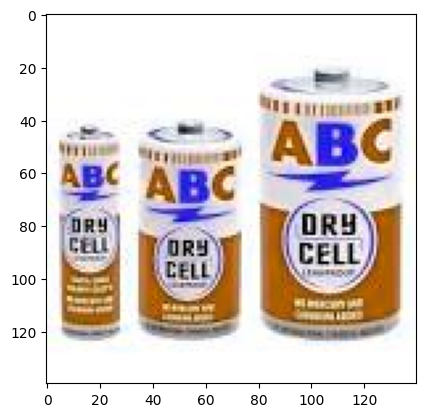

In [4]:
img = cv2.imread(os.path.join(data_dir, 'baterai', 'baterai_10.jpg'))
plt.imshow(img)

## 1. PreProcess and Data Load

### 1.1 Load Data

In [5]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 7063 files belonging to 18 classes.


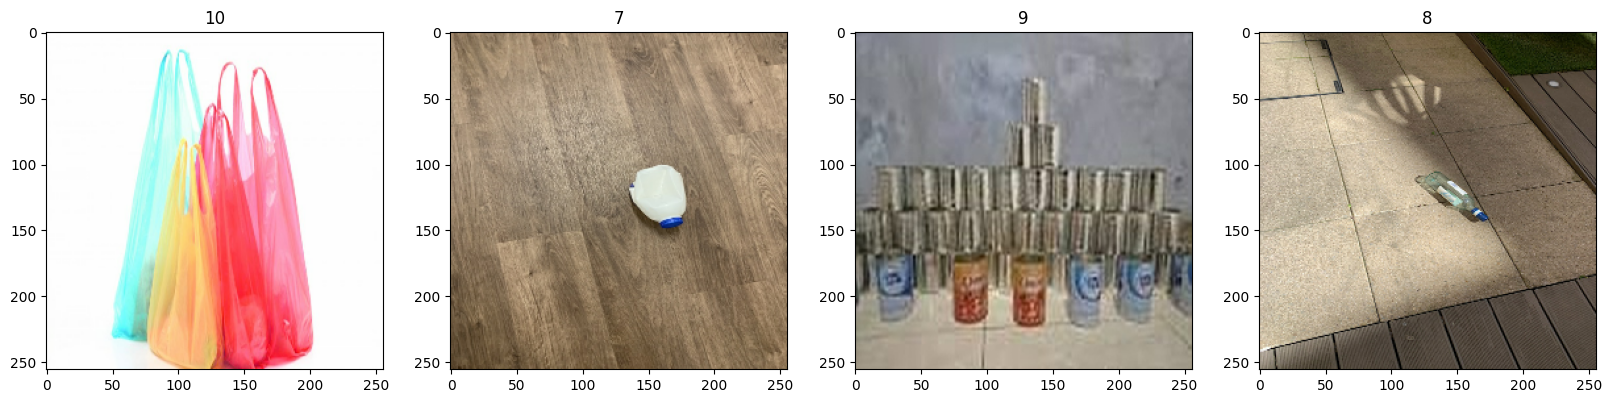

In [6]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### 1.2 Augmented Data

In [7]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),  # Randomly zoom images up to 10%
    layers.RandomContrast(0.2),  # Randomly change the contrast of images
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Randomly translate images up to 10% in height and width
])

# Normalize the data
data = data.map(lambda x, y: (x / 255, y))

# # Apply data augmentation
data = data.map(lambda x, y: (data_augmentation(x, training=True), y))

### 1.3 Scale Data

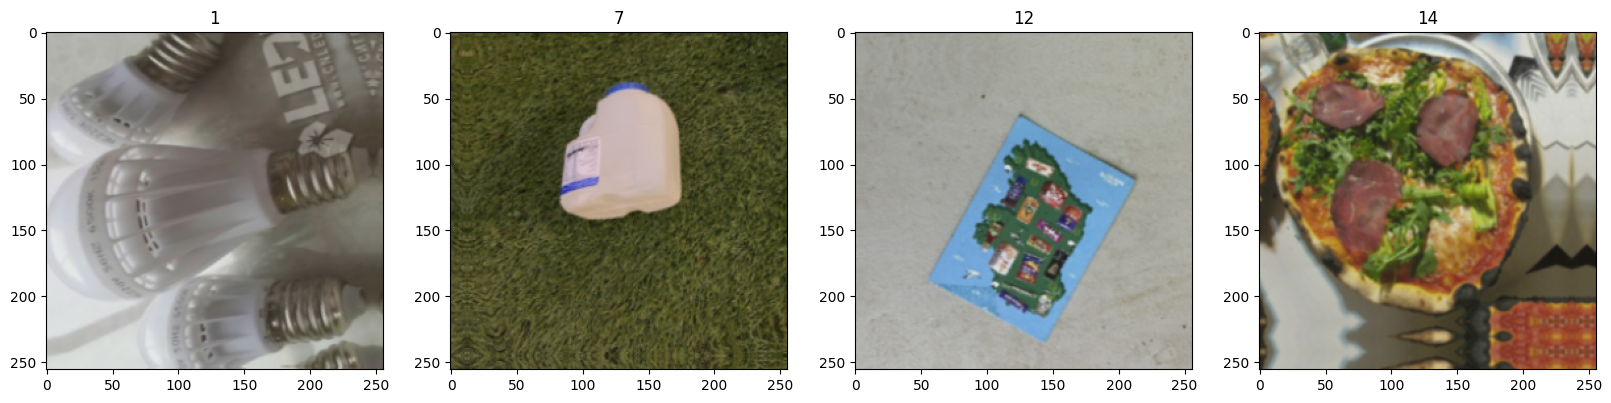

In [8]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])

### 1.4 Split Data

In [9]:
len(data)

221

In [10]:
train_size = int(len(data)*.7)+1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [11]:
train_size

155

In [12]:
val_size

44

In [13]:
test_size

22

In [14]:
train_size+val_size+test_size

221

In [15]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## 2. Build and Train (From Scracth)

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout

model = Sequential()
classification = 18

### 2.1 Build Model

In [20]:
from tensorflow.keras import regularizers

# # Define the L1 or L2 regularizer
# # Note: You can adjust the value of l1 or l2 based on your preference
reg = regularizers.l1_l2(l1=1e-5, l2=1e-4)

model.add(Conv2D(100, (3,3), 1, activation='relu', input_shape=(256,256,3), kernel_regularizer=reg))
model.add(MaxPooling2D())

model.add(Conv2D(200, (3,3), 1, activation='relu', kernel_regularizer=reg))
model.add(MaxPooling2D())

model.add(Conv2D(100, (3,3), 1, activation='relu', kernel_regularizer=reg))
model.add(MaxPooling2D())

model.add(Conv2D(200, (3,3), 1, activation='relu', kernel_regularizer=reg))
model.add(MaxPooling2D())

model.add(Conv2D(100, (3,3), 1, activation='relu', kernel_regularizer=reg))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.6))
model.add(Dense(classification, activation='softmax', kernel_regularizer=reg))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 100)  │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 100)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 200)  │       180,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 100)    │       180,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 200)    │       180,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 100)    │       180,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       921,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,649,882 (6.29 MB)

 Trainable params: 1,649,882 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

### 2.2 Train Model

In [22]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

logdir='logs'
valLoss_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# accr_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# custom_callback = CustomAccuracyThreshold(threshold=0.97)
callbacks = [tensorboard_callback, valLoss_stop]

with tf.device('/GPU:0'):
    hist_test = model.fit(train, epochs=1, validation_data=val)

model.save("model1_test.h5")

with tf.device('/GPU:0'):
    hist = model.fit(train, epochs=30, validation_data=val, callbacks=callbacks)

model.save("model1.h5")

I0000 00:00:1718695031.722846     186 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718695031.743713     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.0488 - loss: 3.0417

W0000 00:00:1718695273.173386     189 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/155 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.0489 - loss: 3.0414 - val_accuracy: 0.1009 - val_loss: 2.8842
Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.0874 - loss: 2.8897 - val_accuracy: 0.1222 - val_loss: 2.7307
Epoch 2/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.1222 - loss: 2.7423 - val_accuracy: 0.1683 - val_loss: 2.6276
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.1497 - loss: 2.6711 - val_accuracy: 0.2266 - val_loss: 2.4515
Epoch 4/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.2002 - loss: 2.4597 - val_accuracy: 0.2720 - val_loss: 2.2075
Epoch 5/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.2588 - loss: 2.2847 - val_accuracy: 0.3267 - val_loss: 2.0972
Epoch 6/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.2970 - loss: 2.1890 - val_accuracy: 0.3217 - val_loss: 2.0918
Epoch 7/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.3202 - loss: 2.1015 - val_accuracy: 0.343

## 3. Model Evaluation (From Scratch)

### 3.1 Plot Performance

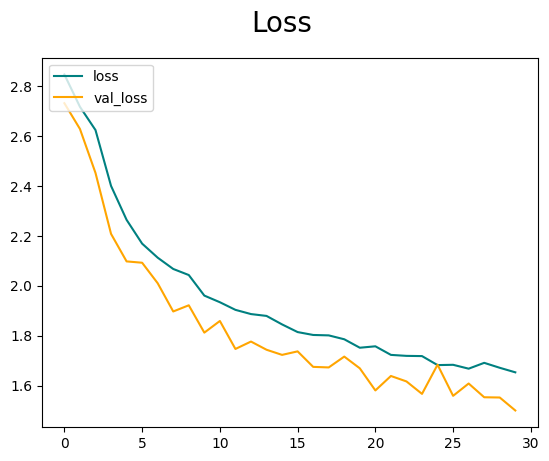

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

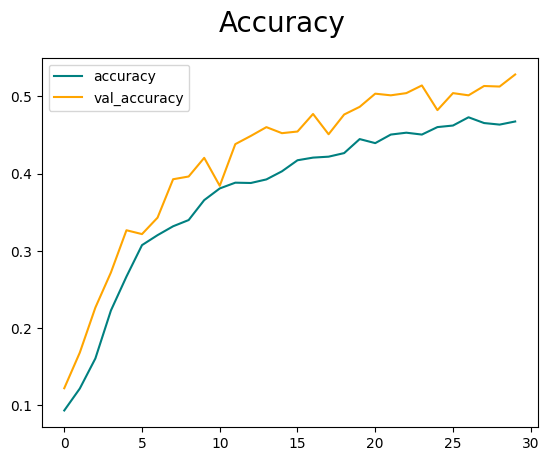

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 3.2 Validation

In [25]:
pre = tf.keras.metrics.Precision()
re = tf.keras.metrics.Recall()
acc = tf.keras.metrics.SparseCategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    # No need to convert predictions to class indices for SparseCategoricalAccuracy
    # yhat = tf.argmax(yhat, axis=1)

    # Update metrics
    pre.update_state(y, tf.argmax(yhat, axis=1))  # Precision and Recall still need class indices
    re.update_state(y, tf.argmax(yhat, axis=1))
    acc.update_state(y, yhat)  # SparseCategoricalAccuracy needs the original predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step


W0000 00:00:1718703624.445625     189 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


W0000 00:00:1718703650.437635     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [26]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9581465125083923, Recall:0.9771341681480408, Accuracy:0.5280575752258301


### 3.3 Testing

In [9]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

model_path = "/kaggle/input/praktikummodul6/tensorflow2/scract1/1/model1.h5"
model = tf.keras.models.load_model(model_path)

# Define the image dimensions
img_height = 256
img_width = 256

image_path = "/kaggle/input/praktikum-ai-modul-6-2024/train/bohlam/bulb (125).jpg"  # Update this with your image folder path

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

img_array = load_and_preprocess_image(image_path)

# Make prediction
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions, axis=1)[0]

print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
3


## 4. Predictions

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load the pre-trained model
model_path = "/kaggle/input/praktikummodul6/tensorflow2/resznet50-2/1/res_model4.h5"
model = tf.keras.models.load_model(model_path)

# Define the image dimensions
img_height = 256
img_width = 256

# Define the class names
class_names = [
    "baterai", "bohlam", "botol_aerosol", "botol_obat", "bungkus_makanan", 
    "cangkang_telur", "daun", "hdpem", "kaca", "kaleng", 
    "kantong_plastik", "kardus", "kertas", "pet", "sisa_makanan", 
    "tablet_kapsul", "termometer", "tissue"
]

# Directory containing the images
image_folder = "/kaggle/input/praktikum-ai-modul-6-2024/test"  # Update this with your image folder path

# Get a list of image file names
image_files = [f for f in os.listdir(image_folder)]

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# List to store results
results = []

i = 0

# Loop over each image file, make predictions, and store results
for img_file in image_files:
    print(i)
    i += 1
    img_path = os.path.join(image_folder, img_file)
    img_array = load_and_preprocess_image(img_path)

    # Make prediction
    predictions = model.predict(img_array)
    
    # Get the class with the highest probability
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    
    # Map the predicted class index to the class name
    predicted_class_name = class_names[predicted_class_idx]
    
    # Append image file name and predicted class name to results
    results.append([img_file, predicted_class_name])

# Create a DataFrame from the results
df = pd.DataFrame(results, columns=['file_name', 'label'])

# Save the DataFrame to a CSV file
output_csv = "predictions.csv"
df.to_csv(output_csv, index=False)

print(f"Predictions saved to {output_csv}")

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
24
1/